# Gesture Recognition

<strong>__Objective__</strong>
>Imagine you are working as a data scientist at a home electronics company which manufactures state of the art `smart televisions`. You want to develop a cool feature in the smart-TV that can `recognise five different gestures` performed by the user which will help users control the TV without using a remote.

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 25 #experiment with the batch size

**Let us create a function for cropping image**

In [4]:
def crop_img(img, scale=1.0):
    center_x,     center_y      = img.shape[1] / 2,             img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale,         img.shape[0] * scale
    left_x,       right_x       = center_x - width_scaled / 2,  center_x + width_scaled / 2
    top_y,        bottom_y      = center_y - height_scaled / 2, center_y + height_scaled / 2
    
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    
    return img_cropped

## Generator-1
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        # num_batches = # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,18,64,64,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping Image
                    image = crop_img(image, 0.10)
                    # Resizing the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64), interpolation = cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalizing and feeding the image
                    # batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data   = np.zeros((len(t)%batch_size,18,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size, 5))
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+t[folder+(num_batches*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image
                    image = crop_img(image, 0.1)
                    
                    # Resizing image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                        
                    # Normalizing and feeding the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs
print('# epochs =', num_epochs)
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 5
# batch_size = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# Additional libraries
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, ZeroPadding3D
# from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras.losses import categorical_crossentropy
# from keras import optimizers
# #from keras.optimizers import Adam, SGD
# from keras.layers.recurrent import GRU, LSTM


In [7]:
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

#write your model here

## Building first model - 3D Conv Model

In the first model, not using dropouts in the Conv Layer with batch normalization. <br/>
Input size is considered as 64x64.

In [8]:
model1 = Sequential()

model1.add(Conv3D(8,(3,3,3), padding='same', input_shape=(18,64,64,3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(16,(3,3,3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(32,(3,3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(64,(3,3,3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Dense(5, activation='softmax'))

2023-11-27 04:52:06.850447: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-11-27 04:52:06.850512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14806 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
# optimiser = #write your optimizer
optimiser = optimizers.Adam(learning_rate=0.0002, decay=1e-6)
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 64, 64, 8)     656       
                                                                 
 activation (Activation)     (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization (BatchN  (None, 18, 64, 64, 8)    32        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 32, 32, 8)     0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_1 (Activation)   (None, 9, 32, 32, 16)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit` generator.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model1-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

# WARNING:tensorflow:`period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen or at the end of each epoch.
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

# LR = # write the REducelronplateau code here
LR = ReduceLROnPlateau(Monitor='val_los', factor=0.2, patience=3, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `.fit` generator method to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
# model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

history = model1.fit(train_generator, 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=num_epochs, 
                     verbose=1, 
                     callbacks=callbacks_list, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, 
                     class_weight=None, 
                     workers=1, 
                     initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/5


2023-11-27 04:52:31.390218: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 2.2826 - categorical_accuracy: 0.2187Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model1_init_2023-11-2704_51_52.162506/model1-00001-2.28262-0.21870-2.28262-0.21870.h5
27/27 [==============================] - 26s 854ms/step - loss: 2.2826 - categorical_accuracy: 0.2187 - val_loss: 1.6139 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.8574 - categorical_accuracy: 0.2926
Epoch 00002: saving model to model1_init_2023-11-2704_51_52.162506/model1-00002-1.85739-0.29261-1.85739-0.29261.h5
27/27 [==============================] - 20s 768ms/step - loss: 1.8574 - categorical_accuracy: 0.2926 - val_loss: 1.6492 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.6941 - categorical_accuracy: 0.3514
Epoch 00003: saving model to model1_init_2023-11-2704_

**Let us plot the model1 result**

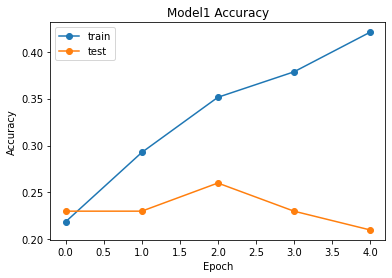

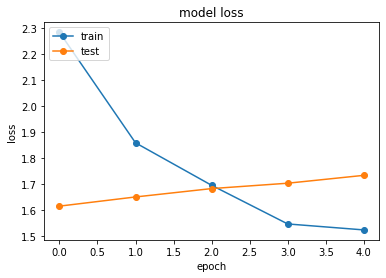

In [14]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In our model we got the training accuracy of 42% and the validation accuracy of 21% only.

## Building Second model - 3D Conv Model

In the this model, not using dropouts in the Conv Layer with batch normalization. <br/>
Input size is considered as 64x64. <br/>
adam potimizer with learning rate of 0.0002, no decay. <br/>
dropout updated to 0.50 from 0.25 in the 1st dense layer. <br/>

In [15]:
batch_size = 30
num_epochs = 20

In [16]:
# Model Building
model2 = Sequential()

model2.add(Conv3D(8,(3,3,3), padding='same', input_shape=(18,64,64,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(16,(3,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(32,(3,3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(64,(3,3,3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.50))

model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.50))

model2.add(Dense(5, activation='softmax'))

In [17]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam(learning_rate=0.0002)
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_4 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_6 (Batc  (None, 18, 64, 64, 8)    32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_5 (Activation)   (None, 9, 32, 32, 16)    

Creating 'train_generator' and 'val_generator'.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model2-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
history = model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,use_multiprocessing=False,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.4549 - categorical_accuracy: 0.2353Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model2_init_2023-11-2704_51_52.162506/model2-00001-2.45488-0.23529-2.45488-0.23529.h5
23/23 [==============================] - 22s 946ms/step - loss: 2.4549 - categorical_accuracy: 0.2353 - val_loss: 1.6295 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 2.4378 - categorical_accuracy: 0.2549
Epoch 00002: saving model to model2_init_2023-11-2704_51_52.162506/model2-00002-2.43781-0.25490-2.43781-0.25490.h5
23/23 [==============================] - 20s 891ms/step - loss: 2.4378 - categorical_accuracy: 0.2549 - val_loss: 1.6557 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
22/23 [===========================>..] - ETA: 0s - loss: 2.2087 - cat

**Let us plot the model2**

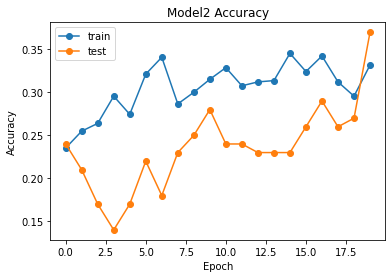

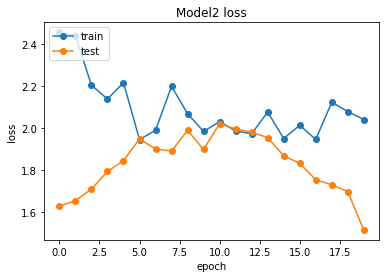

In [22]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Seems the valudation accuracy of 37% is improved compared to the previous model.

## Building Third model - 3D Conv Model

In the this model, not using dropouts in the Conv Layer with batch normalization. <br/>
Input size is considered as 84x84. <br/>
Cropping reduced to 3% from 10%. <br/>
adam potimizer with learning rate of 0.0002, no decay. <br/>
dropout updated to 0.25 from 0.50 in the 1st dense layer. <br/>

## Generator-2

In [23]:
# Updating Generator funciton
def generator2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    
    while True:
        t = np.random.permutation(folder_list)
        
        # num_batches = # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,18,84,84,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping Image
                    image = crop_img(image, 0.03)
                    # Resizing the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84), interpolation = cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalizing and feeding the image
                    # batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data   = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size, 5))
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+t[folder+(num_batches*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image
                    image = crop_img(image, 0.03)
                    
                    # Resizing image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                        
                    # Normalizing and feeding the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [24]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 30


In [25]:
# Model Building
model3 = Sequential()

model3.add(Conv3D(8,(3,3,3), padding='same', input_shape=(18,84,84,3)))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(16,(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(32,(3,3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(64,(3,3,3), padding='same'))
model3.add(Activation('relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(5, activation='softmax'))

In [26]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam(learning_rate=0.0002)
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 84, 84, 8)     656       
                                                                 
 activation_8 (Activation)   (None, 18, 84, 84, 8)     0         
                                                                 
 batch_normalization_12 (Bat  (None, 18, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 42, 42, 8)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 42, 42, 16)     3472      
                                                                 
 activation_9 (Activation)   (None, 9, 42, 42, 16)    

In [27]:
train_generator = generator2(train_path, train_doc, batch_size)
val_generator = generator2(val_path, val_doc, batch_size)

In [28]:
model_name = 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model3-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
history = model3.fit(train_generator, 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=num_epochs, 
                     verbose=1, 
                     callbacks=callbacks_list, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, 
                     class_weight=None,
                     workers=1, 
                     initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.2013 - categorical_accuracy: 0.2383Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model3_init_2023-11-2705_03_31.332787/model3-00001-2.20129-0.23831-2.20129-0.23831.h5
23/23 [==============================] - 40s 2s/step - loss: 2.2013 - categorical_accuracy: 0.2383 - val_loss: 1.6345 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.8107 - categorical_accuracy: 0.3288
Epoch 00002: saving model to model3_init_2023-11-2705_03_31.332787/model3-00002-1.81070-0.32881-1.81070-0.32881.h5
23/23 [==============================] - 27s 1s/step - loss: 1.8107 - categorical_accuracy: 0.3288 - val_loss: 1.6202 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.5903 - categoric

**Let us plot the model3**	

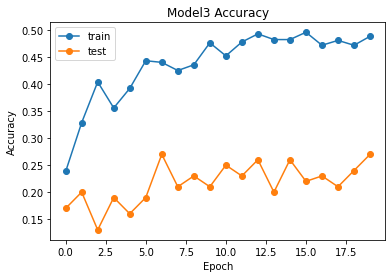

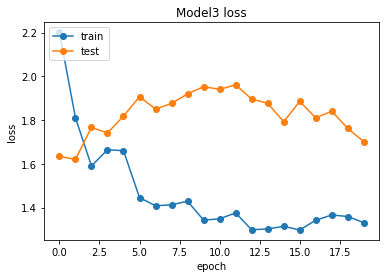

In [31]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This module has given us the valudation accuracy of 27%.

## Building Fourth model - 3D Conv Model

In this model, Input size is considered as 100x100. <br/>
Cropping reduced to 2% from 3%. <br/>

In [32]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

## Generator-4

In [33]:
# Updating Generator funciton
def generator4(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    
    while True:
        t = np.random.permutation(folder_list)
        
        # num_batches = # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,18,100,100,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping Image
                    image = crop_img(image, 0.02)
                    # Resizing the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100), interpolation = cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalizing and feeding the image
                    # batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data   = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size, 5))
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+t[folder+(num_batches*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image
                    image = crop_img(image, 0.02)
                    
                    # Resizing image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                        
                    # Normalizing and feeding the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [34]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 50
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batch_size = 50


In [35]:
# Model Building
model4 = Sequential()

model4.add(Conv3D(8,(3,3,3), padding='same', input_shape=(18,100,100,3)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(16,(3,3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(32,(1,3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(64,(1,3,3), padding='same'))
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.25))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.25))

model4.add(Dense(5, activation='softmax'))

In [36]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam()
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 100, 100, 8)   656       
                                                                 
 batch_normalization_18 (Bat  (None, 18, 100, 100, 8)  32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 18, 100, 100, 8)   0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 50, 50, 16)     3472      
                                                                 
 batch_normalization_19 (Bat  (None, 9, 50, 50, 16)   

In [37]:
train_generator = generator4(train_path, train_doc, batch_size)
val_generator = generator4(val_path, val_doc, batch_size)

In [38]:
model_name = 'model4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model4-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [39]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
history = model4.fit(train_generator, 
                     steps_per_epoch=steps_per_epoch,
                     epochs=num_epochs, 
                     verbose=1, 
                     callbacks=callbacks_list, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, 
                     class_weight=None,
                     use_multiprocessing=False,
                     workers=1, 
                     initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 50
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 2.0431 - categorical_accuracy: 0.2640Source path =  /home/datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model4_init_2023-11-2705_13_59.596848/model4-00001-2.04306-0.26395-2.04306-0.26395.h5
14/14 [==============================] - 29s 2s/step - loss: 2.0431 - categorical_accuracy: 0.2640 - val_loss: 1.6068 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5631 - categorical_accuracy: 0.3032
Epoch 00002: saving model to model4_init_2023-11-2705_13_59.596848/model4-00002-1.56307-0.30317-1.56307-0.30317.h5
14/14 [==============================] - 29s 2s/step - loss: 1.5631 - categorical_accuracy: 0.3032 - val_loss: 1.6129 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.5124 - categorical_accur

**Let us plot the model4**	

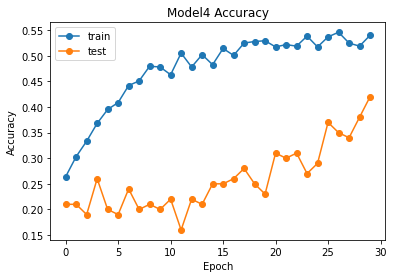

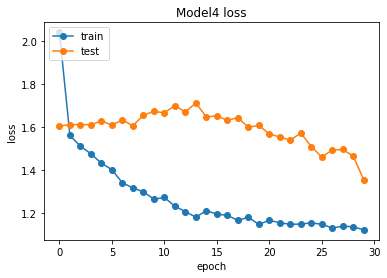

In [41]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

We can see this model has given the validation accuracy of 42% which is better than the previous one.

## Building Fifth model - 3D Conv Model

In the this model, Input size is considered as 84x84. <br/>

## Generator-5

In [42]:
# Updating Generator funciton
def generator5(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    
    while True:
        t = np.random.permutation(folder_list)
        
        # num_batches = # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,30,84,84,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping Image
                    # image = crop_img(image, 0.02)
                    # Resizing the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84), interpolation = cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalizing and feeding the image
                    # batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data   = np.zeros((len(t)%batch_size,30,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size, 5))
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+t[folder+(num_batches*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image
                    # image = crop_img(image, 0.02)
                    
                    # Resizing image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                        
                    # Normalizing and feeding the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [43]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 30
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batch_size = 30


In [44]:
# Model Building
model5 = Sequential()

model5.add(Conv3D(8,(3,3,3), padding='same', input_shape=(30,84,84,3)))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(16,(3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(32,(3,3,3), padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(64,(3,3,3), padding='same'))
model5.add(Activation('relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))
model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.25))

model5.add(Dense(5, activation='softmax'))

In [45]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam(learning_rate=0.0002)
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 84, 84, 8)     656       
                                                                 
 activation_16 (Activation)  (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_21 (Bat  (None, 30, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 42, 42, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 42, 42, 16)    3472      
                                                                 
 activation_17 (Activation)  (None, 15, 42, 42, 16)   

In [46]:
train_generator = generator5(train_path, train_doc, batch_size)
val_generator = generator5(val_path, val_doc, batch_size)

In [47]:
model_name = 'model5_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model5-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [48]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [49]:
history = model5.fit(train_generator, 
                     steps_per_epoch=steps_per_epoch,
                     epochs=num_epochs, 
                     verbose=1, 
                     callbacks=callbacks_list, 
                     validation_data=val_generator, 
                     validation_steps=validation_steps, 
                     class_weight=None,
                     workers=1, 
                     initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.9598 - categorical_accuracy: 0.3137Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model5_init_2023-11-2705_30_42.068738/model5-00001-1.95978-0.31373-1.95978-0.31373.h5
23/23 [==============================] - 59s 3s/step - loss: 1.9598 - categorical_accuracy: 0.3137 - val_loss: 1.6321 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5461 - categorical_accuracy: 0.4027
Epoch 00002: saving model to model5_init_2023-11-2705_30_42.068738/model5-00002-1.54609-0.40271-1.54609-0.40271.h5
23/23 [==============================] - 51s 2s/step - loss: 1.5461 - categorical_accuracy: 0.4027 - val_loss: 1.6926 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2871 - categoric

**Let us plot the model5**	

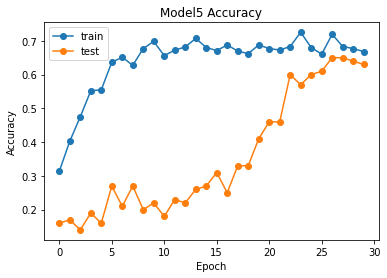

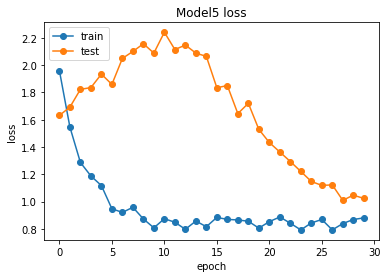

In [50]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model5 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Finally we have received the test accuracy of 66.82% and validation accuracy of 63% using convolutional model which is very good compared to the previous one.

## Since the performance of Conv3D model is not so good, 
## Let us try with LSTM Model

In [51]:
input_shape = (30,120,120,3)

## Generator-6

In [52]:
# Updating Generator funciton
def generator6_lstm(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    
    while True:
        t = np.random.permutation(folder_list)
        
        # num_batches = # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,30,120,120,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping Image
                    # image = crop_img(image, 0.02)
                    # Resizing the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120), interpolation = cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalizing and feeding the image
                    # batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data   = np.zeros((len(t)%batch_size,30,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size, 5))
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+t[folder+(num_batches*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image
                    # image = crop_img(image, 0.02)
                    
                    # Resizing image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                        
                    # Normalizing and feeding the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [53]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 20


In [54]:
from tensorflow.keras.layers import TimeDistributed

In [55]:
# Model Building
model6_lstm = Sequential()

model6_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model6_lstm.add(TimeDistributed(BatchNormalization()))
model6_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model6_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model6_lstm.add(TimeDistributed(BatchNormalization()))
model6_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model6_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model6_lstm.add(TimeDistributed(BatchNormalization()))
model6_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model6_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model6_lstm.add(TimeDistributed(BatchNormalization()))
model6_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model6_lstm.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model6_lstm.add(TimeDistributed(BatchNormalization()))
model6_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model6_lstm.add(TimeDistributed(Flatten()))
model6_lstm.add(LSTM(128))
model6_lstm.add(Dropout(0.25))
model6_lstm.add(Dense(128,activation='relu'))
model6_lstm.add(Dropout(0.25))
model6_lstm.add(Dense(5, activation='softmax'))

In [56]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam()
model6_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6_lstm.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

In [57]:
train_generator = generator6_lstm(train_path, train_doc, batch_size)
val_generator = generator6_lstm(val_path, val_doc, batch_size)

In [58]:
model_name = 'model6_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model6-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [59]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [60]:
history = model6_lstm.fit(train_generator, 
                          steps_per_epoch=steps_per_epoch,
                          epochs=num_epochs, 
                          verbose=1, 
                          callbacks=callbacks_list, 
                          validation_data=val_generator, 
                          validation_steps=validation_steps, 
                          class_weight=None, 
                          workers=1, 
                          initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4153 - categorical_accuracy: 0.3620Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model6_init_2023-11-2706_01_17.617920/model6-00001-1.41525-0.36199-1.41525-0.36199.h5
34/34 [==============================] - 56s 2s/step - loss: 1.4153 - categorical_accuracy: 0.3620 - val_loss: 1.7487 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1233 - categorical_accuracy: 0.5324
Epoch 00002: saving model to model6_init_2023-11-2706_01_17.617920/model6-00002-1.12332-0.53243-1.12332-0.53243.h5
34/34 [==============================] - 51s 2s/step - loss: 1.1233 - categorical_accuracy: 0.5324 - val_loss: 2.1265 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0139 - categorical_accur

**Let us plot the model6**	

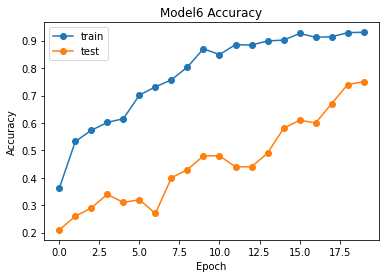

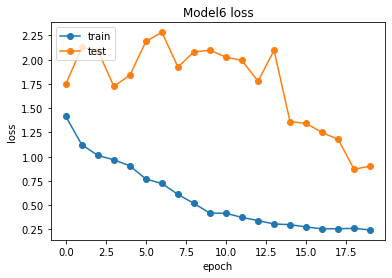

In [61]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model6 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model has given us the training accuracy of 93% and validation accuracy of 75%, which is again a good process.

## Creating new Model7 with CNN-LSTM

In this model, let us increase the image size to 160x160.

In [62]:
input_shape = (30,160,160,3)

## Generator-7

In [63]:
# Updating Generator funciton
def generator7_lstm(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    
    while True:
        t = np.random.permutation(folder_list)
        
        # num_batches = # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,30,160,160,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping Image
                    # image = crop_img(image, 0.02)
                    # Resizing the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160), interpolation = cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalizing and feeding the image
                    # batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data   = np.zeros((len(t)%batch_size,30,160,160,3))
            batch_labels = np.zeros((len(t)%batch_size, 5))
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+t[folder+(num_batches*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image
                    # image = crop_img(image, 0.02)
                    
                    # Resizing image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(160,160),interpolation = cv2.INTER_AREA).astype(np.float32)
                        
                    # Normalizing and feeding the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [64]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 20


In [65]:
# Model Building
model7_lstm = Sequential()

model7_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model7_lstm.add(TimeDistributed(BatchNormalization()))
model7_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model7_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model7_lstm.add(TimeDistributed(BatchNormalization()))
model7_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model7_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model7_lstm.add(TimeDistributed(BatchNormalization()))
model7_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model7_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model7_lstm.add(TimeDistributed(BatchNormalization()))
model7_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model7_lstm.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model7_lstm.add(TimeDistributed(BatchNormalization()))
model7_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

model7_lstm.add(TimeDistributed(Flatten()))
model7_lstm.add(LSTM(128))
model7_lstm.add(Dropout(0.25))
model7_lstm.add(Dense(128,activation='relu'))
model7_lstm.add(Dropout(0.25))
model7_lstm.add(Dense(5, activation='softmax'))

In [66]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam()
model7_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7_lstm.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 160, 160, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 160, 160, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 80, 80, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 80, 80, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 80, 80, 32)  

In [67]:
train_generator = generator7_lstm(train_path, train_doc, batch_size)
val_generator = generator7_lstm(val_path, val_doc, batch_size)

In [68]:
model_name = 'model7_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model7-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [69]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [70]:
history = model7_lstm.fit(train_generator, 
                          steps_per_epoch=steps_per_epoch,
                          epochs=num_epochs, 
                          verbose=1, 
                          callbacks=callbacks_list, 
                          validation_data=val_generator, 
                          validation_steps=validation_steps, 
                          class_weight=None, 
                          workers=1, 
                          initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4798 - categorical_accuracy: 0.3575Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model7_init_2023-11-2706_21_50.528684/model7-00001-1.47975-0.35747-1.47975-0.35747.h5
34/34 [==============================] - 68s 2s/step - loss: 1.4798 - categorical_accuracy: 0.3575 - val_loss: 1.8662 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1557 - categorical_accuracy: 0.5279
Epoch 00002: saving model to model7_init_2023-11-2706_21_50.528684/model7-00002-1.15573-0.52790-1.15573-0.52790.h5
34/34 [==============================] - 64s 2s/step - loss: 1.1557 - categorical_accuracy: 0.5279 - val_loss: 1.8491 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0943 - categorical_accur

**Let us plot the model7**	

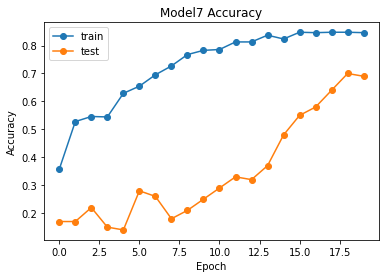

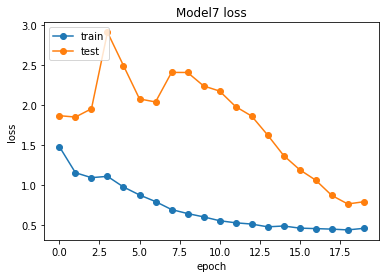

In [71]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model7 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model has given us the test accuracy of 84.62% and validation accuracy of 69%, which is not good compared to the previous model.

## Creating new Model8 

In this model, let us:
* Increase the layers and
* epoch to 25

In [72]:
input_shape = (30,120,120,3)

In [73]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 25
# batch_size = 20


In [74]:
# Model Building
model8_lstm = Sequential()

model8_lstm.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
model8_lstm.add(Activation('relu'))
model8_lstm.add(BatchNormalization())

model8_lstm.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
model8_lstm.add(Activation('relu'))
model8_lstm.add(BatchNormalization())
model8_lstm.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8_lstm.add(Conv3D(32, (3, 3, 3), padding='same'))
model8_lstm.add(Activation('relu'))
model8_lstm.add(BatchNormalization())

model8_lstm.add(Conv3D(32, (3, 3, 3), padding='same'))
model8_lstm.add(Activation('relu'))
model8_lstm.add(BatchNormalization())
model8_lstm.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8_lstm.add(Conv3D(64, (3, 3, 3), padding='same'))
model8_lstm.add(Activation('relu'))
model8_lstm.add(BatchNormalization())

model8_lstm.add(Conv3D(64, (3, 3, 3), padding='same'))
model8_lstm.add(Activation('relu'))
model8_lstm.add(BatchNormalization())
model8_lstm.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8_lstm.add(Conv3D(128, (3, 3, 3), padding='same'))
model8_lstm.add(Activation('relu'))
model8_lstm.add(BatchNormalization())

model8_lstm.add(Conv3D(128, (3, 3, 3), padding='same'))
model8_lstm.add(Activation('relu'))
model8_lstm.add(BatchNormalization())
model8_lstm.add(MaxPooling3D(pool_size=(2, 2, 2)))


model8_lstm.add(Flatten())
model8_lstm.add(Dense(64,activation='relu'))
model8_lstm.add(BatchNormalization())
model8_lstm.add(Dropout(0.25))
model8_lstm.add(Dense(64,activation='relu'))
model8_lstm.add(BatchNormalization())
model8_lstm.add(Dropout(0.25))

model8_lstm.add(Dense(5, activation='softmax'))

In [75]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam()
model8_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8_lstm.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_37 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_21 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_21 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_38 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [76]:
train_generator = generator6_lstm(train_path, train_doc, batch_size)
val_generator = generator6_lstm(val_path, val_doc, batch_size)

In [77]:
model_name = 'model8_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model8-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [78]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [79]:
history = model8_lstm.fit(train_generator, 
                          steps_per_epoch=steps_per_epoch,
                          epochs=num_epochs, 
                          verbose=1, 
                          callbacks=callbacks_list, 
                          validation_data=val_generator, 
                          validation_steps=validation_steps, 
                          class_weight=None, 
                          workers=1, 
                          initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6489 - categorical_accuracy: 0.4027Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model8_init_2023-11-2706_45_05.719601/model8-00001-1.64892-0.40271-1.64892-0.40271.h5
34/34 [==============================] - 61s 2s/step - loss: 1.6489 - categorical_accuracy: 0.4027 - val_loss: 2.9497 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2763 - categorical_accuracy: 0.4917
Epoch 00002: saving model to model8_init_2023-11-2706_45_05.719601/model8-00002-1.27631-0.49170-1.27631-0.49170.h5
34/34 [==============================] - 57s 2s/step - loss: 1.2763 - categorical_accuracy: 0.4917 - val_loss: 2.7603 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1343 - categorical_accur

**Let us plot the model8**	

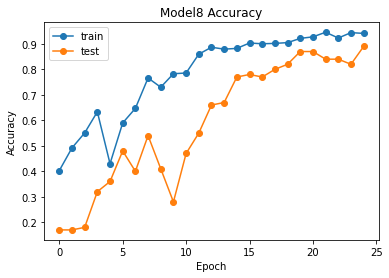

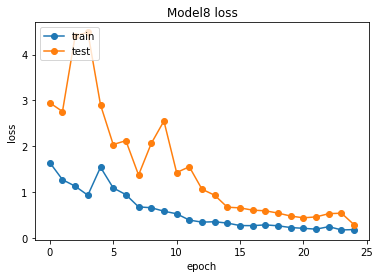

In [80]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model8 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model8 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model has given us the test accuracy of 94.12% and validation accuracy of 89%, which is again better one.

## Creating new Model9 

In this model, let us:
* Change the parameters Convolutional Network parameters

In [81]:
input_shape = (30,120,120,3)

In [82]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 20
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 25
# batch_size = 20


In [83]:
# Model Building
model9_lstm = Sequential()

model9_lstm.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
model9_lstm.add(Activation('relu'))
model9_lstm.add(BatchNormalization())

model9_lstm.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
model9_lstm.add(Activation('relu'))
model9_lstm.add(BatchNormalization())
model9_lstm.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9_lstm.add(Conv3D(32, (3, 3, 3), padding='same'))
model9_lstm.add(Activation('relu'))
model9_lstm.add(BatchNormalization())

model9_lstm.add(Conv3D(32, (3, 3, 3), padding='same'))
model9_lstm.add(Activation('relu'))
model9_lstm.add(BatchNormalization())
model9_lstm.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9_lstm.add(Conv3D(64, (3, 3, 3), padding='same'))
model9_lstm.add(Activation('relu'))
model9_lstm.add(BatchNormalization())

model9_lstm.add(Conv3D(64, (3, 3, 3), padding='same'))
model9_lstm.add(Activation('relu'))
model9_lstm.add(BatchNormalization())
model9_lstm.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9_lstm.add(Conv3D(128, (3, 3, 3), padding='same'))
model9_lstm.add(Activation('relu'))
model9_lstm.add(BatchNormalization())

model9_lstm.add(Conv3D(128, (3, 3, 3), padding='same'))
model9_lstm.add(Activation('relu'))
model9_lstm.add(BatchNormalization())
model9_lstm.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9_lstm.add(Flatten())
model9_lstm.add(Dense(128,activation='relu'))
model9_lstm.add(BatchNormalization())
model9_lstm.add(Dropout(0.25))
model9_lstm.add(Dense(128,activation='relu'))
model9_lstm.add(BatchNormalization())
model9_lstm.add(Dropout(0.25))

model9_lstm.add(Dense(5, activation='softmax'))

In [84]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam()
model9_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9_lstm.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_47 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_29 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_29 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [85]:
train_generator = generator6_lstm(train_path, train_doc, batch_size)
val_generator = generator6_lstm(val_path, val_doc, batch_size)

In [86]:
model_name = 'model9_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model9-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [87]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [88]:
history = model9_lstm.fit(train_generator, 
                          steps_per_epoch=steps_per_epoch,
                          epochs=num_epochs, 
                          verbose=1, 
                          callbacks=callbacks_list, 
                          validation_data=val_generator, 
                          validation_steps=validation_steps, 
                          class_weight=None, 
                          workers=1, 
                          initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5285 - categorical_accuracy: 0.4359Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model9_init_2023-11-2707_08_34.264448/model9-00001-1.52847-0.43590-1.52847-0.43590.h5
34/34 [==============================] - 56s 2s/step - loss: 1.5285 - categorical_accuracy: 0.4359 - val_loss: 1.6947 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2125 - categorical_accuracy: 0.5339
Epoch 00002: saving model to model9_init_2023-11-2707_08_34.264448/model9-00002-1.21252-0.53394-1.21252-0.53394.h5
34/34 [==============================] - 56s 2s/step - loss: 1.2125 - categorical_accuracy: 0.5339 - val_loss: 2.9931 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1116 - categorical_accur

**Let us plot the model9**	

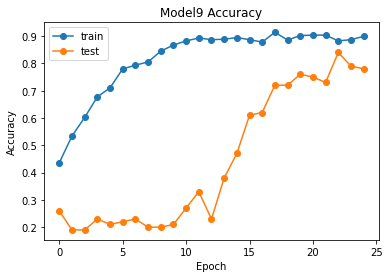

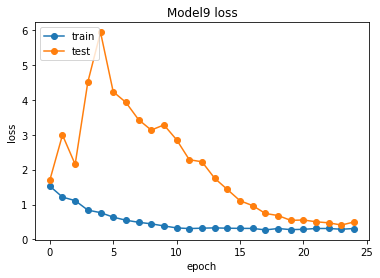

In [89]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model9 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model9 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model has given us the test accuracy of 89.89% and validation accuracy of 78%, which is not good compared to the previous one.

## Building new Model10 - LSTM with GRU 


In [119]:
input_shape = (30,120,120,3)

In [120]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 5
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 5


In [123]:
# Model Building
model10_lstmGRU = Sequential()

model10_lstmGRU.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
model10_lstmGRU.add(TimeDistributed(BatchNormalization()))
model10_lstmGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model10_lstmGRU.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model10_lstmGRU.add(TimeDistributed(BatchNormalization()))
model10_lstmGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model10_lstmGRU.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model10_lstmGRU.add(TimeDistributed(BatchNormalization()))
model10_lstmGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model10_lstmGRU.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model10_lstmGRU.add(TimeDistributed(BatchNormalization()))
model10_lstmGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model10_lstmGRU.add(TimeDistributed(Flatten()))

model10_lstmGRU.add(GRU(128))
model10_lstmGRU.add(Dropout(0.25))

model10_lstmGRU.add(Dense(128, activation='relu'))
model10_lstmGRU.add(Dropout(0.25))

model10_lstmGRU.add(Dense(5, activation='softmax'))

In [124]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam()
model10_lstmGRU.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10_lstmGRU.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_123 (TimeD  (None, 30, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_124 (TimeD  (None, 30, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_125 (TimeD  (None, 30, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_126 (TimeD  (None, 30, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_127 (TimeD  (None, 30, 60, 60, 32) 

In [125]:
train_generator = generator6_lstm(train_path, train_doc, batch_size)
val_generator = generator6_lstm(val_path, val_doc, batch_size)

In [126]:
model_name = 'model10_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model10-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [127]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [128]:
history = model10_lstmGRU.fit(train_generator, 
                          steps_per_epoch=steps_per_epoch,
                          epochs=num_epochs, 
                          verbose=1, 
                          callbacks=callbacks_list, 
                          validation_data=val_generator, 
                          validation_steps=validation_steps, 
                          class_weight=None, 
                          workers=1, 
                          initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.6385 - categorical_accuracy: 0.3198Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model10_init_2023-11-2708_02_58.989884/model10-00001-1.63854-0.31976-1.63854-0.31976.h5
133/133 [==============================] - 45s 328ms/step - loss: 1.6385 - categorical_accuracy: 0.3198 - val_loss: 2.4037 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.2945 - categorical_accuracy: 0.4766
Epoch 00002: saving model to model10_init_2023-11-2708_02_58.989884/model10-00002-1.29451-0.47662-1.29451-0.47662.h5
133/133 [==============================] - 43s 326ms/step - loss: 1.2945 - categorical_accuracy: 0.4766 - val_loss: 2.4029 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 1.1933 -

**Let us plot the model10**	

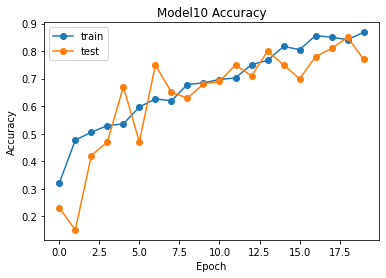

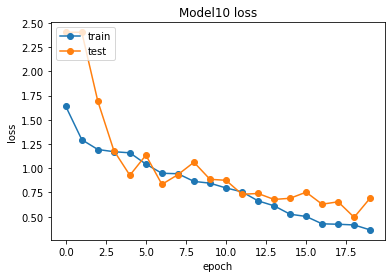

In [129]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model10 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model10 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model has given us the test accuracy of 86.88% and validation accuracy of 77%, which is not good compared to the previous one.

## Creating new Model11 - Transfer Learning

In [130]:
# Importing Model
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 2s 0us/step


## Generator-11

In [131]:
# Updating Generator funciton for transfer learning
def generator11_tl(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = [1, 2, 4, 6, 7, 8, 10, 12, 14, 16, 18, 20, 21, 22, 24, 26, 27, 29]
    
    while True:
        t = np.random.permutation(folder_list)
        
        # num_batches = # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,18,120,120,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+t[folder+(batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping Image
                    # image = crop_img(image, 0.02)
                    # Resizing the image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120), interpolation = cv2.INTER_AREA).astype(np.float32)
                    
                    # Normalizing and feeding the image
                    # batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data   = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size, 5))
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+t[folder+(num_batches*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+t[folder+(num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
                    # Cropping image
                    # image = crop_img(image, 0.02)
                    
                    # Resizing image
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                        
                    # Normalizing and feeding the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder+(num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [132]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 5
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 5


In [133]:
input_shape = (18,120,120,3)

In [136]:
# Model Building
model11_tl = Sequential()

model11_tl.add(TimeDistributed(mobilenet_transfer, input_shape=input_shape))

for layer in model11_tl.layers:
    layer.trainable = False

model11_tl.add(TimeDistributed(BatchNormalization()))
model11_tl.add(TimeDistributed(MaxPooling2D((2, 2))))

model11_tl.add(TimeDistributed(Flatten()))

model11_tl.add(LSTM(128))
model11_tl.add(Dropout(0.25))

model11_tl.add(Dense(128,activation='relu'))
model11_tl.add(Dropout(0.25))

model11_tl.add(Dense(5, activation='softmax'))

In [137]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam()
model11_tl.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11_tl.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_137 (TimeD  (None, 18, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_138 (TimeD  (None, 18, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_139 (TimeD  (None, 18, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_140 (TimeD  (None, 18, 1024)         0         
 istributed)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 128)             

In [138]:
train_generator = generator11_tl(train_path, train_doc, batch_size)
val_generator = generator11_tl(val_path, val_doc, batch_size)

In [139]:
model_name = 'model11_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model11-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [140]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [141]:
history = model11_tl.fit(train_generator, 
                          steps_per_epoch=steps_per_epoch,
                          epochs=num_epochs, 
                          verbose=1, 
                          callbacks=callbacks_list, 
                          validation_data=val_generator, 
                          validation_steps=validation_steps, 
                          class_weight=None, 
                          workers=1, 
                          initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3428 - categorical_accuracy: 0.4314Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model11_init_2023-11-2708_31_20.983420/model11-00001-1.34281-0.43137-1.34281-0.43137.h5
133/133 [==============================] - 33s 221ms/step - loss: 1.3428 - categorical_accuracy: 0.4314 - val_loss: 1.0817 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7845 - categorical_accuracy: 0.7044
Epoch 00002: saving model to model11_init_2023-11-2708_31_20.983420/model11-00002-0.78454-0.70437-0.78454-0.70437.h5
133/133 [==============================] - 27s 207ms/step - loss: 0.7845 - categorical_accuracy: 0.7044 - val_loss: 0.7632 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4454 -

**Let us plot the model11**	

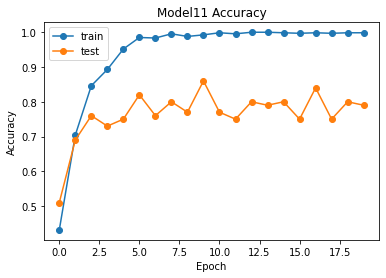

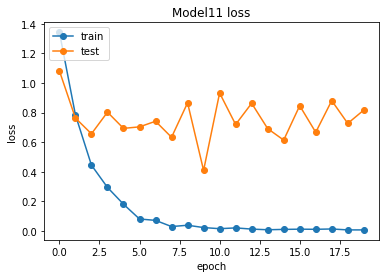

In [142]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model11 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model11 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model has given us the test accuracy of 99.85% and validation accuracy of 79%, which shows growth in the training accuracy as well as validation accuracy.

## Creating new Model12 - Transfer Learning with GRU

In [143]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [144]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 5
print('# batch_size =',batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 5


In [145]:
input_shape = (18,120,120,3)

In [147]:
# Model Building
model12_tl = Sequential()

model12_tl.add(TimeDistributed(mobilenet_transfer, input_shape=input_shape))

model12_tl.add(TimeDistributed(BatchNormalization()))
model12_tl.add(TimeDistributed(MaxPooling2D((2, 2))))

model12_tl.add(TimeDistributed(Flatten()))

model12_tl.add(GRU(128))
model12_tl.add(Dropout(0.25))

model12_tl.add(Dense(128,activation='relu'))
model12_tl.add(Dropout(0.25))

model12_tl.add(Dense(5, activation='softmax'))

In [148]:
# Writing optimizer and compiling the model
optimiser = optimizers.Adam()
model12_tl.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model12_tl.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_141 (TimeD  (None, 18, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_142 (TimeD  (None, 18, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_143 (TimeD  (None, 18, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_144 (TimeD  (None, 18, 1024)         0         
 istributed)                                                     
                                                                 
 gru_8 (GRU)                 (None, 128)             

In [149]:
train_generator = generator11_tl(train_path, train_doc, batch_size)
val_generator = generator11_tl(val_path, val_doc, batch_size)

In [150]:
model_name = 'model12_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model12-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

In [151]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [152]:
history = model12_tl.fit(train_generator, 
                          steps_per_epoch=steps_per_epoch,
                          epochs=num_epochs, 
                          verbose=1, 
                          callbacks=callbacks_list, 
                          validation_data=val_generator, 
                          validation_steps=validation_steps, 
                          class_weight=None, 
                          workers=1, 
                          initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.1407 - categorical_accuracy: 0.5566Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model12_init_2023-11-2708_43_45.072801/model12-00001-1.14069-0.55656-1.14069-0.55656.h5
133/133 [==============================] - 35s 232ms/step - loss: 1.1407 - categorical_accuracy: 0.5566 - val_loss: 0.7149 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.5813 - categorical_accuracy: 0.8220
Epoch 00002: saving model to model12_init_2023-11-2708_43_45.072801/model12-00002-0.58129-0.82202-0.58129-0.82202.h5
133/133 [==============================] - 29s 222ms/step - loss: 0.5813 - categorical_accuracy: 0.8220 - val_loss: 0.6814 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5343 -

**Let us plot the model12**	

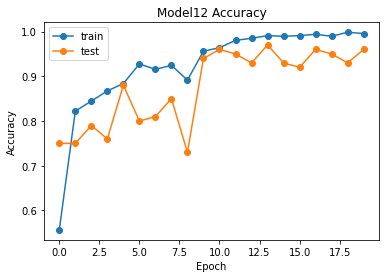

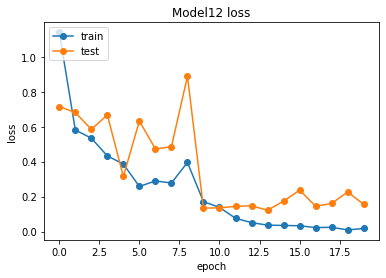

In [153]:
# Plotting model accuracy history
plt.plot(history.history['categorical_accuracy'], 'o-')
plt.plot(history.history['val_categorical_accuracy'], 'o-')
plt.title('Model12 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plotting model loss history
plt.plot(history.history['loss'], 'o-')
plt.plot(history.history['val_loss'], 'o-')
plt.title('Model12 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

This model has given us the test accuracy of 99.55% and validation accuracy of 96% which is the best accuracry among all other models.

# <u>Final Model Selection </u>

As we have seen the last Model12 has given us the best training accuracy as well as the best test accuracy.
Hence, marking the model `model12-00020-0.01745-0.99548-0.01745-0.99548.h5` as the final one.

Thank you.